## Next Word Prediction using RNN

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
import requests

url = "https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt"

# Fetching the content of the text file from the URL
response = requests.get(url)

# Checking if the request was successful
if response.status_code == 200:
    # Reading the content of the text file
    text_content = response.text
    
    # Printing the first 500 characters to check if the file is loaded properly
    print(text_content[:100])
else:
    print("Failed to fetch the file. Status code:", response.status_code)


That, poor contempt, or claim'd thou slept so faithful,
I may contrive our father; and, in their def


In [6]:
#storing words in a list
words = text_content.split()
words[:10]

['That,',
 'poor',
 'contempt,',
 'or',
 "claim'd",
 'thou',
 'slept',
 'so',
 'faithful,',
 'I']

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[' '] = 0
itos = {i:s for s,i in stoi.items()}

pprint(itos)
pprint(stoi)

{0: ' ',
 1: '!',
 2: "'",
 3: ',',
 4: '-',
 5: '.',
 6: ':',
 7: ';',
 8: '?',
 9: 'A',
 10: 'B',
 11: 'C',
 12: 'D',
 13: 'E',
 14: 'F',
 15: 'G',
 16: 'H',
 17: 'I',
 18: 'J',
 19: 'K',
 20: 'L',
 21: 'M',
 22: 'N',
 23: 'O',
 24: 'P',
 25: 'Q',
 26: 'R',
 27: 'S',
 28: 'T',
 29: 'U',
 30: 'V',
 31: 'W',
 32: 'X',
 33: 'Y',
 34: 'Z',
 35: 'a',
 36: 'b',
 37: 'c',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'i',
 44: 'j',
 45: 'k',
 46: 'l',
 47: 'm',
 48: 'n',
 49: 'o',
 50: 'p',
 51: 'q',
 52: 'r',
 53: 's',
 54: 't',
 55: 'u',
 56: 'v',
 57: 'w',
 58: 'x',
 59: 'y',
 60: 'z'}
{' ': 0,
 '!': 1,
 "'": 2,
 ',': 3,
 '-': 4,
 '.': 5,
 ':': 6,
 ';': 7,
 '?': 8,
 'A': 9,
 'B': 10,
 'C': 11,
 'D': 12,
 'E': 13,
 'F': 14,
 'G': 15,
 'H': 16,
 'I': 17,
 'J': 18,
 'K': 19,
 'L': 20,
 'M': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'Q': 25,
 'R': 26,
 'S': 27,
 'T': 28,
 'U': 29,
 'V': 30,
 'W': 31,
 'X': 32,
 'Y': 33,
 'Z': 34,
 'a': 35,
 'b': 36,
 'c': 37,
 'd': 38,
 'e': 39,
 'f': 40,


In [9]:
import nltk
nltk.download('punkt')
sentences = nltk.sent_tokenize(text_content)
sentences[:10]

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


["That, poor contempt, or claim'd thou slept so faithful,\nI may contrive our father; and, in their defeated queen,\nHer flesh broke me and puttance of expedition house,\nAnd in that same that ever I lament this stomach,\nAnd he, nor Butly and my fury, knowing everything\nGrew daily ever, his great strength and thought\nThe bright buds of mine own.",
 "BIONDELLO:\nMarry, that it may not pray their patience.'",
 'KING LEAR:\nThe instant common maid, as we may less be\na brave gentleman and joiner: he that finds us with wax\nAnd owe so full of presence and our fooder at our\nstaves.',
 "It is remorsed the bridal's man his grace\nfor every business in my tongue, but I was thinking\nthat he contends, he hath respected thee.",
 "BIRON:\nShe left thee on, I'll die to blessed and most reasonable\nNature in this honour, and her bosom is safe, some\nothers from his speedy-birth, a bill and as\nForestem with Richard in your heart\nBe question'd on, nor that I was enough:\nWhich of a partier fort

In [11]:
# Tokenize each sentence into characters
block_size = 50  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for sentence in sentences:
    chars = list(sentence)  # Tokenize sentence into characters
    context = [0] * block_size
    for ch in chars + ['.']:  # Add '.' to indicate end of sentence
        ix = stoi.get(ch, 0)  # Use get() method to handle unknown characters
        X.append(context)
        Y.append(ix)
        context_str = ''.join(itos[i] for i in context)  # Handle unknown characters
        ix_str = itos[ix] 
        print(context_str, '--->', ix_str)
        context = context[1:] + [ix]  # crop and append
      

                                                   ---> T
                                                 T ---> h
                                                Th ---> a
                                               Tha ---> t
                                              That ---> ,
                                             That, --->  
                                            That,  ---> p
                                           That, p ---> o
                                          That, po ---> o
                                         That, poo ---> r
                                        That, poor --->  
                                       That, poor  ---> c
                                      That, poor c ---> o
                                     That, poor co ---> n
                                    That, poor con ---> t
                                   That, poor cont ---> e
                                  That, poor conte ---> m
              

In [12]:
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([99411, 50]), torch.int64, torch.Size([99411]), torch.int64)

In [13]:
# Embedding layer for the context

emb_dim = 8
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 1.4561e-01,  1.9583e+00, -9.2502e-01, -3.2620e-01, -2.0553e-01,
          6.3530e-01,  1.0683e+00,  7.1415e-01],
        [ 2.7264e+00, -1.5143e+00,  6.9660e-01, -1.0243e+00,  1.0744e+00,
          5.5996e-01,  1.1573e+00, -2.4727e+00],
        [-1.5954e+00,  4.1111e-01,  4.8105e-01,  3.9994e-01,  9.0099e-02,
         -1.0518e+00, -2.2469e-01,  7.3143e-01],
        [ 6.1082e-02, -4.0155e-01,  8.9799e-01, -1.6639e+00, -1.2715e+00,
          2.5148e-01, -3.3388e-01,  1.5472e+00],
        [-4.7797e-01,  2.0877e+00, -1.0183e+00,  4.1785e-01,  1.1113e-02,
          5.9652e-01, -4.9276e-02, -8.1467e-01],
        [ 1.3803e-01,  1.3136e+00,  1.2670e+00, -7.2153e-02,  5.0011e-01,
         -4.2364e-01,  7.1429e-01,  2.8644e+00],
        [ 2.8650e-01, -1.3126e+00,  5.6779e-01, -9.3922e-02, -7.5000e-01,
         -1.3513e+00,  4.7209e-01,  1.1898e+00],
        [-8.1179e-01, -1.9727e+00,  9.8421e-01,  1.0355e+00, -2.8563e-02,
         -1.7673e+00, -8.9440e-02,  1.2003e

In [14]:
emb.weight.shape

torch.Size([61, 8])

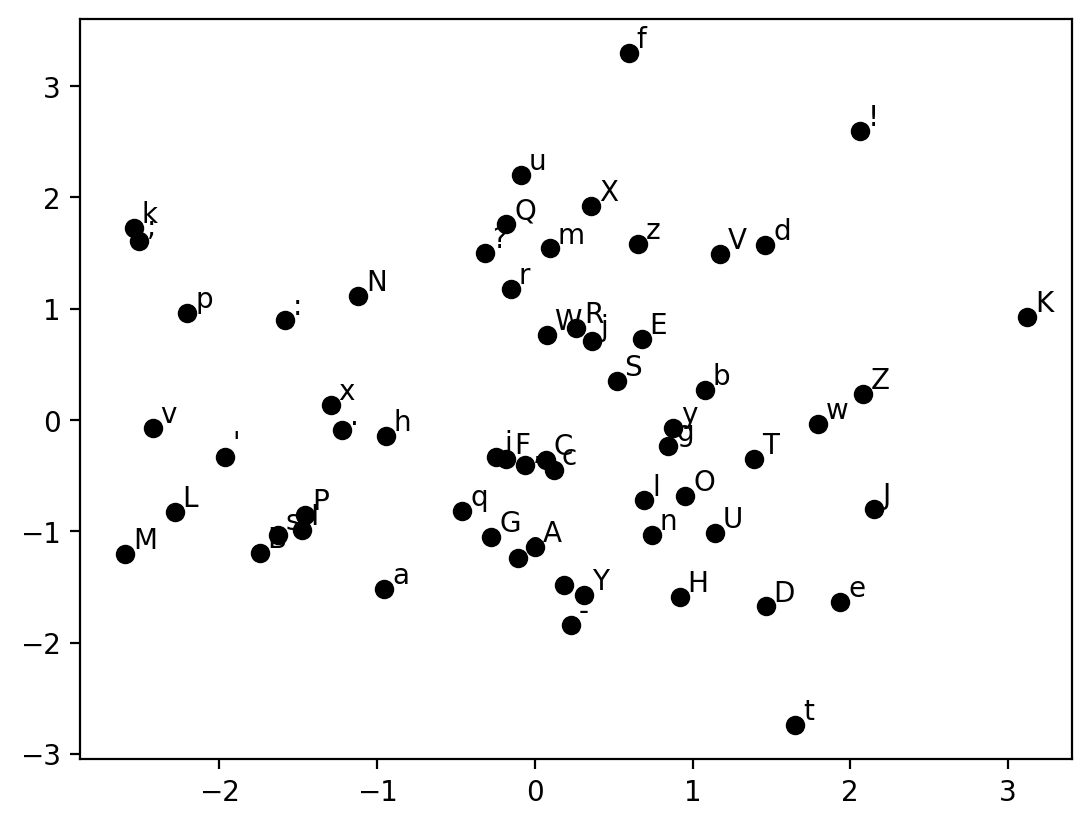

In [15]:
# Function to visualize the embedding in 2d space
def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Selecting the first two dimensions of the embeddings
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(emb.weight.detach().cpu().numpy())

    for i in range(len(itos)):
        x, y = embeddings_2d[i]
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

# Assuming emb.weight has shape [60, 8]
plot_emb(emb, itos)
plt.show()


In [16]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x
    

In [17]:
# Generate names from untrained model

hidden_size = 10
random_seed = 4000002
model = NextChar(block_size, len(stoi), emb_dim, hidden_size ).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(random_seed)
def generate_name(context, model, itos, stoi, block_size, max_len=50):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


arIDLeP ogam-bdPXhBwVqPORAP;LVcdAH-QLs!QFfYI;DbPFM
t'BHKmRsY'sEcbLPQqzFzMOeHT
NDMnRU!DxP;YOMmmAcZBxDSfYAQxL'o
,BTZs tiJYB cPv-,pXQ
VZHPhKC XIotEEZdWwHDUGx-HffVMLTqT-HZpGeLKPqpeJ
ZseUmvP?Ddj!QBPssVUbmguIgcNGeP;U,kbkZFvBSFEhoJP;vv
jxO
 oBiUPmvsXGg!oaW;UL
AdfBAttIIRM J-OHiR;HQoJJgBWDM?qUrStaeLTFhdWDxNz?DU
pmTyIv:heScDqJXfLSQY,WQt:eQbZCI,:htfgQcDGT'O:,E!EZ


In [18]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([61, 8])
_orig_mod.lin1.weight torch.Size([10, 400])
_orig_mod.lin1.bias torch.Size([10])
_orig_mod.lin2.weight torch.Size([61, 10])
_orig_mod.lin2.bias torch.Size([61])


In [19]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(1000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 3.093315362930298
100 2.0325281620025635
200 2.024627685546875
300 2.016653299331665
400 2.0192298889160156
500 2.019939422607422
600 2.020472288131714
700 2.0204944610595703
800 2.020310640335083
900 2.018324375152588


<Axes: >

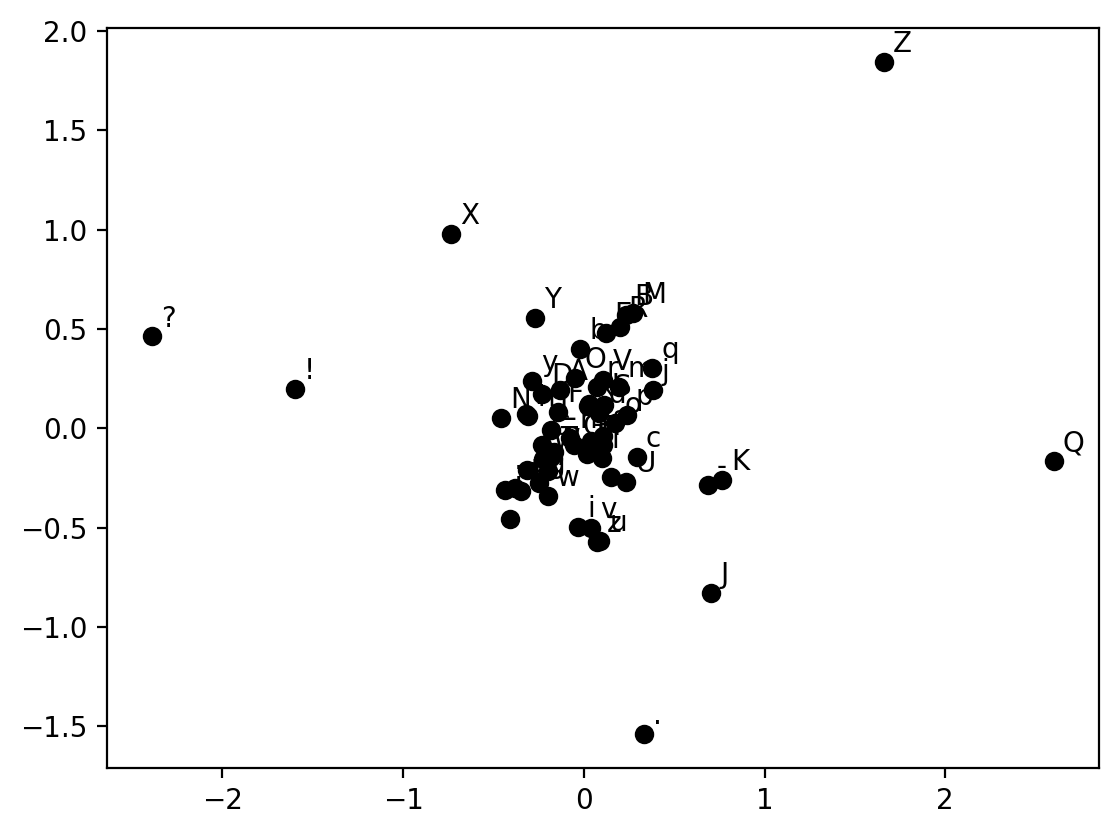

In [20]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [21]:
# Generate k characters from the trained model
k = 10
for i in range(k):
    print(generate_name(model, itos, stoi, block_size))

I se wo sand thall oED: apeos lart, Hope in and df
Darly and ladtufsy beats, by hhou-laks
are Bigctralcsy han thel' por ho wel, turs ines?
PHORCARN: As os i thaen we mrat mios well ir yan' 
Thapt owhar mout sars, Callouns fums and bugh do s
KINN: 'ro-nourt heaic forate's to:sosiofe swer too
KRILIO: I davarvastrye trofs tos Wevinry, insee on
Selovens, dold this besens lieck wen to deorpeatk 
FHONT-- Itotledenfungar hiblact JUVSMTAO you, a; I
K' I't pray nord: mu; Mod gresblett by Praer'd hor


In [28]:
def generate_name(context, model, itos, stoi, block_size, k=1, max_len=50):
    context = context[-block_size:]  # Ensure context is no longer than block_size
    context += ' ' * (block_size - len(context))  # Pad with spaces if shorter than block_size
    name = context  # Initialize name with the provided context
    for i in range(k):
        x = torch.tensor([stoi[ch] for ch in context]).unsqueeze(0).to(device)  # Add batch dimension
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + ch  # Slide the window by one character
    return name

# Example usage:
context = input("Enter the context: ")
generated_name = generate_name(context, model, itos, stoi, block_size, k=5)
print("Generated name:", generated_name[50:])


In [ ]:
import streamlit as st
import torch


# Define your model, itos, stoi, block_size, and device here

def main():
    st.title("Name Generation App")

    # Input text box for user to enter context
    context = st.text_input("Enter the context:")

    # Slider for selecting the value of k
    k = st.slider("Select the value of k", min_value=1, max_value=10, value=5)

    # Drop-down menu with possible inputs
    possible_inputs = ["Option 1", "Option 2", "Option 3"]  # Replace with your options
    selected_input = st.selectbox("Select an option:", possible_inputs)

    # Button to generate the name
    if st.button("Generate Name"):
        generated_name = generate_name(context, model, itos, stoi, block_size, k=k)
        st.success("Generated name: {}".format(generated_name[50:]))  # Displaying from the 50th character onwards

if __name__ == "__main__":
    main()
